# Re-Querying Our Database

As the last questions only asked about sales data contained in a single table, we need to query the database again to get new information that also contains information about the employees making the sales and the person who is leading them. That means that we'll have to `join` the `OrderDetail` table to the `Employee` table, but you can see there's no explicit connection.

Before we tackle this problem, we'll go ahead and connect the databse just like before.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3 as sqlite
import pandas as pd

conn = sqlite.connect('Northwind_small.sqlite')
cur = conn.cursor()

![Database Schema](Northwind_ERD_updated.png)

On inspection, we can see there's an indirection connection between the `OrderDetail` table and the `EmployeeTable` as long as we go through our `Order` table. However, we're going to have to be smart about how we `join` our tables together. And, rather than bring in ALL that extra information, let's only query the information we want to know:  information that will give us total sales, information that will allow us to join the tables, and information about the employees and team leaders.

In [2]:
query = cur.execute("""SELECT OrderID, UnitPrice, Quantity, Discount,
                        EmployeeID, LastName, FirstName, ReportsTo
                        FROM OrderDetail
                        JOIN [Order] ON OrderDetail.OrderID = [Order].ID
                        JOIN Employee ON [Order].EmployeeID = Employee.ID""").fetchall()

df = pd.DataFrame(query)
df.columns = [x[0] for x in cur.description]
df.head()

,OrderId,UnitPrice,Quantity,Discount,EmployeeId,LastName,FirstName,ReportsTo
0,10248,14.0,12,0.0,5,Buchanan,Steven,2.0
1,10248,9.8,10,0.0,5,Buchanan,Steven,2.0
2,10248,34.8,5,0.0,5,Buchanan,Steven,2.0
3,10249,18.6,9,0.0,6,Suyama,Michael,5.0
4,10249,42.4,40,0.0,6,Suyama,Michael,5.0


# Taking a look at our data

Now that we've pulled everything together, let's perform some basic checks on our data to make sure it's usable and of sufficient quality.

In [3]:
#Number of 'Details' from 'OrderDetail', basically the length of the table
df.shape

(2155, 8)

In [4]:
#How many managers are we looking at?
df.ReportsTo.unique()

array([ 2.,  5., nan])

In [5]:
#Missing data?
df.isnull().sum()

OrderId         0
UnitPrice       0
Quantity        0
Discount        0
EmployeeId      0
LastName        0
FirstName       0
ReportsTo     241
dtype: int64

Some of the orders are missing information about who the seller reports to - this could influence our analysis later. So, let's take a look at this.

In [6]:
#A brief view of the table which would hold only values for which 'ReportsTo' is null
df[df.ReportsTo.isnull()].head()

,OrderId,UnitPrice,Quantity,Discount,EmployeeId,LastName,FirstName,ReportsTo
49,10265,31.2,30,0.0,2,Fuller,Andrew,NaN
50,10265,12.0,20,0.0,2,Fuller,Andrew,NaN
76,10277,36.4,20,0.0,2,Fuller,Andrew,NaN
77,10277,39.4,12,0.0,2,Fuller,Andrew,NaN
83,10280,3.6,12,0.0,2,Fuller,Andrew,NaN


In [7]:
#Number of unique values in this table
df[df.ReportsTo.isnull()].nunique()

OrderId       96
UnitPrice     87
Quantity      36
Discount       6
EmployeeId     1
LastName       1
FirstName      1
ReportsTo      0
dtype: int64

It looks like there's only one employee who doesn't have someone they report to - Andrew Fuller. We can infer this because `nunique` tells us that there's only one first name and one last name that have null values for `ReportsTo`. We can infer from here that Andrew might be running the company, but can't be sure.

We found info on our managers, and even who's running the company (maybe). But, let's dig into the employees that we'll be looking into.

In [8]:
#n employees
df.EmployeeId.unique()

array([5, 6, 4, 3, 9, 1, 8, 2, 7], dtype=int64)

In [9]:
#Re-creating the 'Sale' column from before
df['Sale'] = (df['Quantity'] * df['UnitPrice']) * (1 - df['Discount'])

### Let's start separating out salespeople into separate sets

To start answering the third question, we're going to need to separate the employees into individual sets for comparison. Just as before, we'll also make use of our `remove_outliers` function to trim up this data, since it seemed to help in our last comparison. Let's get started by putting together everything we need.

In [10]:
#remove_outliers depends on Numpy, so we're going to bring it in
import numpy as np

#Define helper function
def remove_outliers(data):
    data = data[data < (data.mean() + (3*data.std()))]
    data = data[data > (data.mean() - (3*data.std()))]
    return data

#Create list which will store our sets of employee sales 
employee_sales = {}
for x in range(1,10):
    dfz = df.loc[df['EmployeeId'] == x]
    employee_sales[x] = remove_outliers(dfz.groupby('OrderId')['Sale'].sum().values)
    
#Check that our list length matches the number of employees we know we'll be examining
len(employee_sales)

9

Since it looks like we've got our sets in order, let's go ahead and proceed as before:  we're going to compare the means of our employees' sales agains the mean of sales overall; and then we're going to plot the distribution of each employee's sales.

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#Generates a list of means that we'll plot
means = []
for x in employee_sales.values():
    means.append(np.mean(x))
    
#Plots the figure/graph
plt.figure(figsize=(15,10))

plt.bar(x = employee_sales.keys(), height = means)
plt.axhline(y = remove_outliers(df.groupby('OrderId')['Sale'].sum().values).mean())

plt.title('Average Employee Sale vs Avg Overall Sale', fontsize=20)
plt.xlabel('Employee ID')
plt.ylabel('Value of Average Sale');

So now we can see a baseline for how our employees are stacking up against each other, but let's take a look at how their sales are distributed using histograms and boxplots.

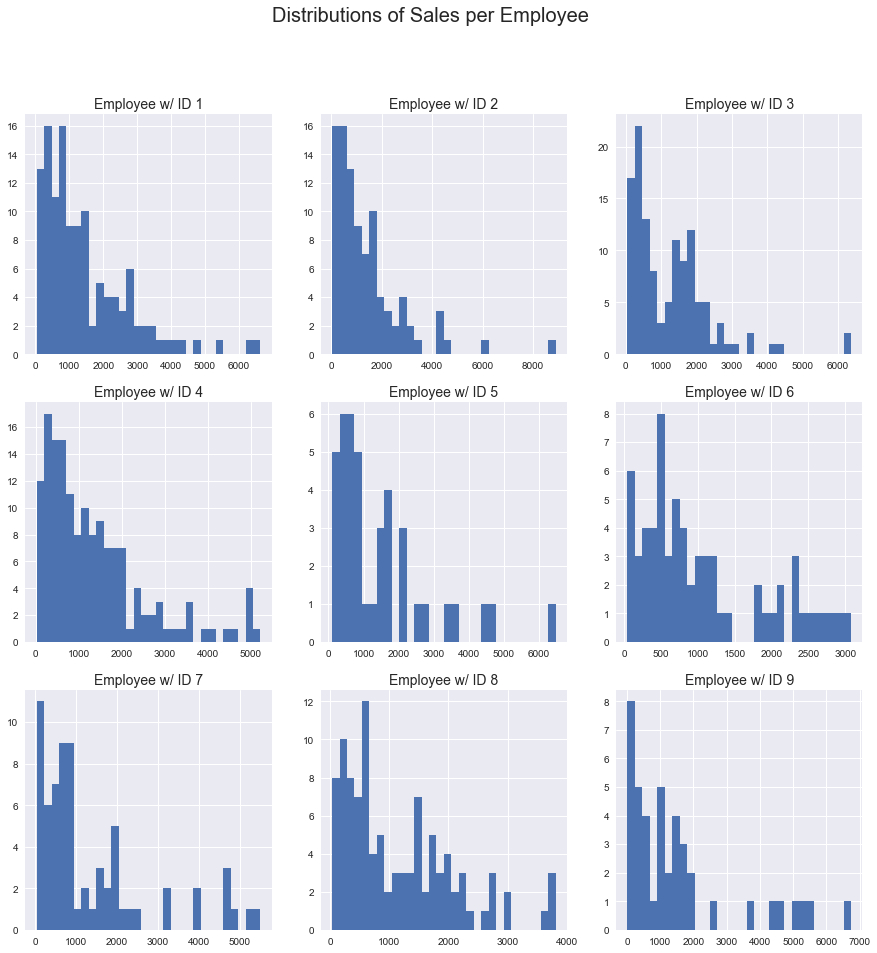

In [12]:
#Makes the figure
fig = plt.figure(figsize = (15, 15))
plt.suptitle('Distributions of Sales per Employee', fontsize=20)

#Iterates over the list of sets to generate subplots
for x in range(1,10):
    plt.subplot(3,3,x)
    plt.hist(employee_sales[x], bins = 30)
    plt.title(f'Employee w/ ID {x}', fontsize=14)

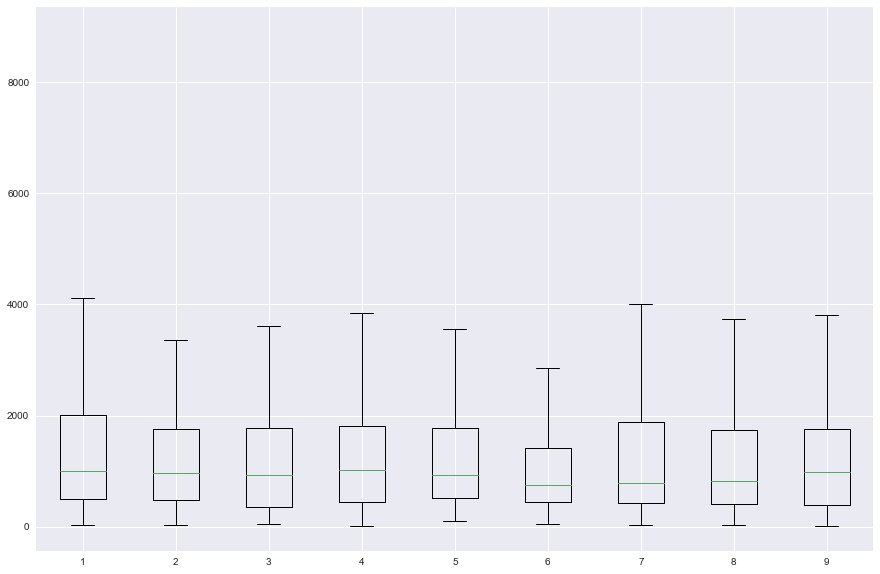

In [13]:
plt.figure(figsize = (15,10))
plt.boxplot(employee_sales.values(), showfliers = True);

# Answering Question 3:  Are some employees outperforming others?

Since we're going to be comparing multiple employees against each other to see if there's a significant difference, we're going to have to use an ANOVA test. We used ANOVA earlier to answer our simple A-B test question because it's robust against non-normal distributions, but another standard application of ANOVA is to make multiple comparisons. 

To make ANOVA comparisons like this, we're going to use StatsModels, which will require a dataframe as an input instead of just an array. So, we need to find a way to encode the employee's into the dataframe in a way that's readable as a category - this means that we're going to have to create a dataframe w/ dummy variables for each employee.

In [14]:
#Since we just need Sales and Employee, we're going to truncate our dataframe
df_sales = df[['Sale', 'EmployeeId']]
df_sales.head()

,Sale,EmployeeId
0,168.0,5
1,98.0,5
2,174.0,5
3,167.4,6
4,1696.0,6


In [15]:
#This will generate a dataframe of dummy variables and preview it
dummies = pd.get_dummies(df_sales['EmployeeId'])
dummies.head()

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


In [16]:
#Check the length of Sales and Dummies to make sure we can merge easily
df_sales.shape, dummies.shape

((2155, 2), (2155, 9))

In [17]:
#Merges the dataframes
#Because they don't have an index column we want to join them on,
#We have to specify that the left and right indices are the same
test = df_sales.merge(dummies, left_index = True, right_index = True)

#Drop the column with EmployeeID because that information has been encoded
test.drop(columns = ['EmployeeId'], inplace = True)

#Assign names to the columns and preview our new frame
test.columns = ['Sale', 'Emp1', 'Emp2',
               'Emp3', 'Emp4', 'Emp5',
               'Emp6', 'Emp7', 'Emp8',
               'Emp9']
test.head()

,Sale,Emp1,Emp2,Emp3,Emp4,Emp5,Emp6,Emp7,Emp8,Emp9
0,168.0,0,0,0,0,1,0,0,0,0
1,98.0,0,0,0,0,1,0,0,0,0
2,174.0,0,0,0,0,1,0,0,0,0
3,167.4,0,0,0,0,0,1,0,0,0
4,1696.0,0,0,0,0,0,1,0,0,0


Looks like our merge was successful, so from here we're going to perform ANOVA using statsmodels. You'll note that because our Employees are 'categories' we have to C-wrap them in the formula so that ANOVA can be correctly run.

In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Sale ~ C(Emp1) + C(Emp2) + C(Emp3) + C(Emp4) + C(Emp5) + C(Emp6) + C(Emp7) + C(Emp8) + C(Emp9)'
lm = ols(formula, test).fit()
table = sm.stats.anova_lm(lm, typ = 2)

#Type 2 ANOVA in this case assumes our variables are all independent and don't share a relationship - so, running this
#type of test assumes our employees aren't cooperating or competing for sales. This assumption might not hold in
#an environment where employees receive sales commissions or bonus incentives.

print(table)

                sum_sq      df         F    PR(>F)
C(Emp1)   1.272526e+05     1.0  0.135948  0.712379
C(Emp2)   6.194724e+06     1.0  6.618044  0.010162
C(Emp3)   2.980100e+06     1.0  3.183747  0.074515
C(Emp4)   1.147528e+05     1.0  0.122595  0.726272
C(Emp5)   3.417463e+05     1.0  0.365100  0.545751
C(Emp6)   1.842197e+06     1.0  1.968084  0.160796
C(Emp7)   5.757159e+06     1.0  6.150578  0.013213
C(Emp8)   7.098239e+05     1.0  0.758330  0.383949
C(Emp9)   4.288218e+06     1.0  4.581256  0.032436
Residual  2.008732e+09  2146.0       NaN       NaN


### ANOVA Results

Since we're coparing multiple groups, we have to use ANOVA, but our overall premise is still the same:  we want to reject the null hypothesis to accept our proposed alternative hypothesis. In this case:

> H0:  There is no variation among employees when it comes to distribution of total sales

> HA:  THere is variation among employees when it comes to the distribution of total sales

We also want to set an alpha value to determine our P value:

> Alpha:  95%, P: 5%

In this case, we got a lot of results. In general, the higher the F statistic (second column from the right), the lower the P-value, implying more significant results. We can see then that only 3 employees meet our "different than average" expectation:

1. Employee 2 
2. Employee 7
3. Employee 9

If we recall from earlier, these three employees were also performing better than average overall. Yet, also were employees 1, 4, and 5. The ANOVA results suggest that even though employees 1, 4, and 5 are also performing above average, it can also be reliably explained by chance. We can take a look at the KDE of these samples versus the total distribution of sales to visualize this effect.

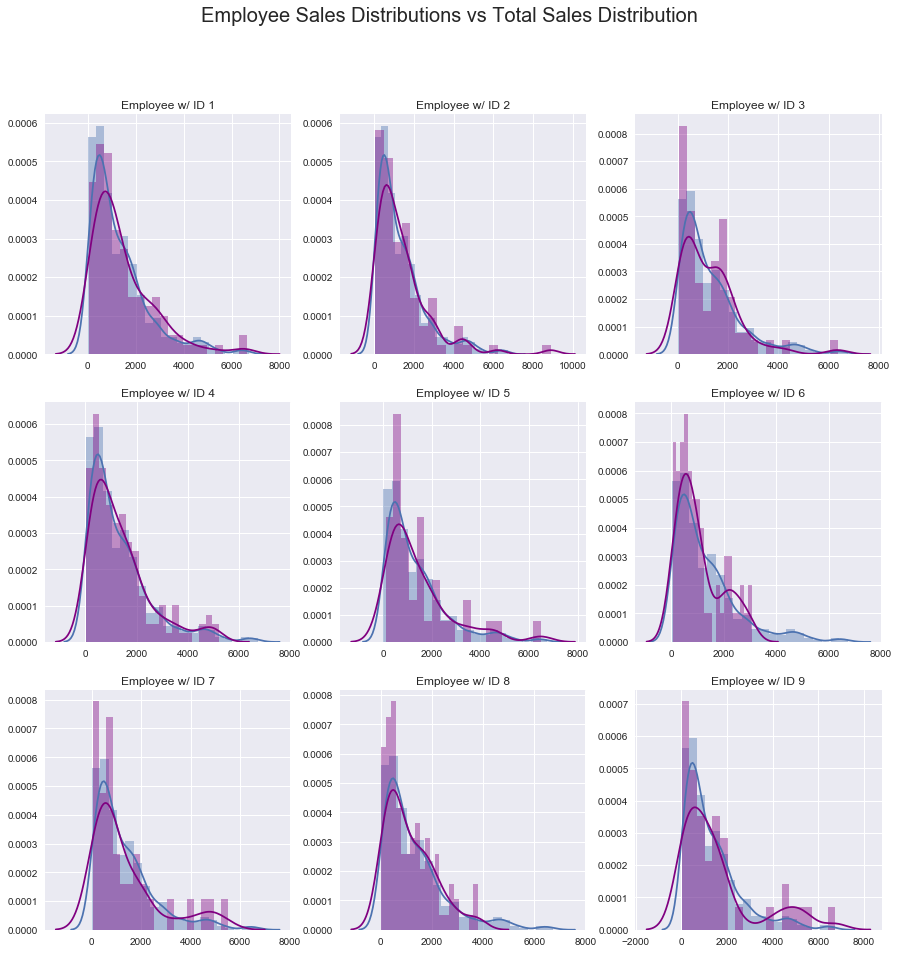

In [19]:
import seaborn as sns

plt.figure(figsize = (15,15))
plt.suptitle('Employee Sales Distributions vs Total Sales Distribution', fontsize = 20)

for x in employee_sales:
    plt.subplot(3,3,x)
    plt.title(f'Employee w/ ID {x}')
    sns.distplot(remove_outliers(df.groupby('OrderId')['Sale'].sum().values), bins=20)
    sns.distplot(employee_sales[x], bins = 20, color = 'purple')

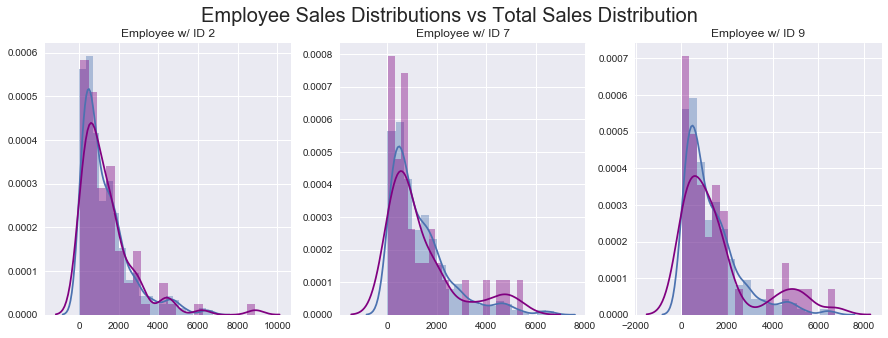

In [20]:
plt.figure(figsize = (15,5))
plt.suptitle('Employee Sales Distributions vs Total Sales Distribution', fontsize = 20)

plt.subplot(1,3,1)
plt.title(f'Employee w/ ID 2')
sns.distplot(remove_outliers(df.groupby('OrderId')['Sale'].sum().values), bins=20)
sns.distplot(employee_sales[2], bins = 20, color = 'purple')

plt.subplot(1,3,2)
plt.title(f'Employee w/ ID 7')
sns.distplot(remove_outliers(df.groupby('OrderId')['Sale'].sum().values), bins=20)
sns.distplot(employee_sales[7], bins = 20, color = 'purple')

plt.subplot(1,3,3)
plt.title(f'Employee w/ ID 9')
sns.distplot(remove_outliers(df.groupby('OrderId')['Sale'].sum().values), bins=20)
sns.distplot(employee_sales[9], bins = 20, color = 'purple');

### What Conclusions Can We Draw?

On reviewing the sales that employees 2, 7, and 9 have closed, there's a statistically significant difference between what their sales look like and everyone elses, and that's a net positive. If we review their distributions, we note that even after significant outliers were removed, employees 2, 7, and 9 have substantail tails - meaning, they're still closing significant numbers of high dollar sales relative to the norm.

From these employees, we might be able to gain useful insights that we can use to coach other members of the team:

* What techniques do they use for pitching/closing/follow-up on a deal?
* Can their performance be further enhanced by using the 5% and 15% discounts?
* How many of their methods can be translated to coach underperforming team members?

Conversely, we can also see that a lot of employees aren't significantly different from each other. We could be asking business questions such as:

* Would performance incentives boost sales values?
* Would positive compeition help improve sales values as well?

# Answering Question 4:  Are managers making a difference?

Something that often comes up at work is, "Where are managers adding value?" In this case, we can look at how our managers teams are doing to see who's leading the most effective team, and to see if they have any sales strategies they are helping their team achieve.

Just as before, we'll perform a simple A-B test by looking at the distribution of sales of both managers and comparing how their teams perform.

In [21]:
#How many unique managers we have
df.ReportsTo.unique()

array([ 2.,  5., nan])

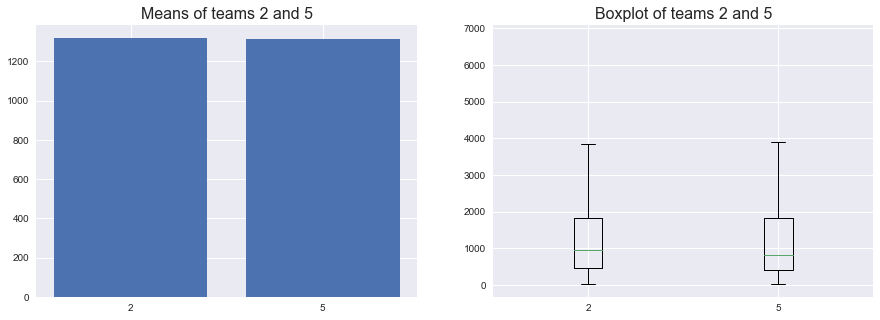

In [22]:
#Separate managers teams' sales into dataframes
df2 = df.loc[df['ReportsTo'] == 2]
df5 = df.loc[df['ReportsTo'] == 5]

#Store that team's truncated sales in a dictionary
team_sales = {}
team_sales[2] = remove_outliers(df2.groupby('OrderId')['Sale'].sum().values)
team_sales[5] = remove_outliers(df5.groupby('OrderId')['Sale'].sum().values)

#Plots means of both teams and shows their boxplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Means of teams 2 and 5', fontsize=16)
plt.bar(x = ['2', '5'], height = [team_sales[2].mean(), team_sales[5].mean()])

plt.subplot(1, 2, 2)
plt.title('Boxplot of teams 2 and 5', fontsize = 16)
plt.boxplot(team_sales.values(), labels=['2', '5']);

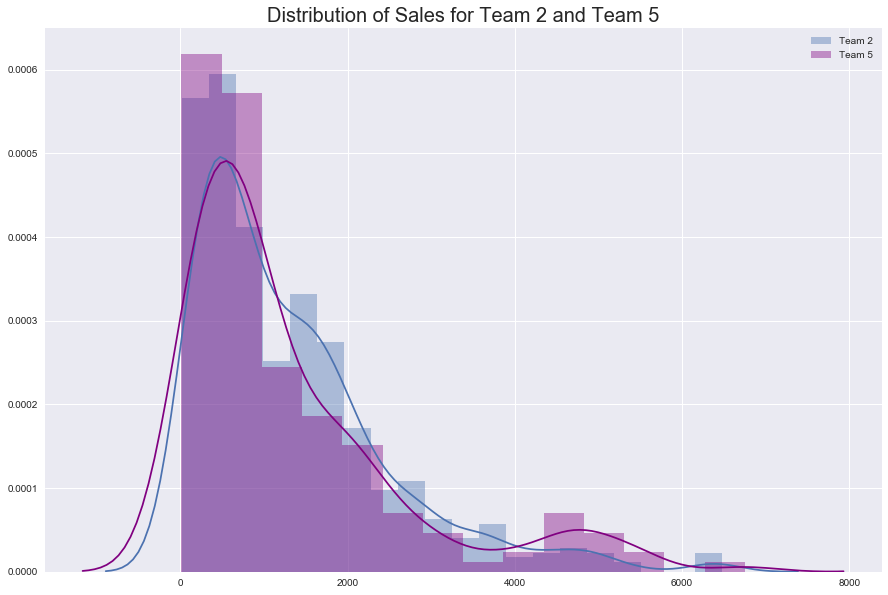

In [23]:
plt.figure(figsize=(15, 10))
plt.title('Distribution of Sales for Team 2 and Team 5', fontsize = 20)
sns.distplot(team_sales[2], label = 'Team 2')
sns.distplot(team_sales[5], color = 'purple', label = 'Team 5')
plt.legend();

From here, it doens't look like there's going to be a big difference between these two teams. However, we can run a quick ANOVA test as in the previous journal to compare these two groups. Let's define our hypotheses again:

> H0: No manager has an appreciable impact on sales.

> HA: Managers impact sales.

> Alpha: 95%, P-Value: 5%

In [24]:
import scipy.stats as stats

result = stats.f_oneway(team_sales[2], team_sales[5])
print(result)

F_onewayResult(statistic=0.0018724923542346435, pvalue=0.9654965157905857)


It looks like, with a p-value of about 0.9, the two sales dollar groups are distributed about the same - meaning that we can't reject the null hypothesis, and it's unlikely that managers are driving the differences between these two groups.

### What Conclusions Can We Draw?

On comparing the sales results of each manager's team, there's no significant difference between the two. This implies that both managers are equally engaged with their employee's sales, and also that teams are flexible - if necessary, a team member from Team 2 could be put into Team 5 without likely having a significant impact.

In this case, espescially at the leadership level, we'd encourage the implementation of performance incentives for managers that are strictly team based. As we saw earlier, Employee 2 - who leads Team 2 - is an exemplary seller, however, if their incentive gets tied to their team's performance, it's possible that we can expect Team 2 pull ahead of Team 5.